# Matlab testbench model state-space matrices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.signal import lsim, dlsim
import opentorsion as ot
import cvxpy as cp

In [2]:
def c2d(A, B, Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    
    return Ad, Bd

In [3]:
time_steps = np.genfromtxt('../data/ice_excitation/times.csv', delimiter=',')
motor = np.genfromtxt('../data/ice_excitation/motor.csv', delimiter=',')
propeller = np.genfromtxt('../data/ice_excitation/propeller.csv', delimiter=',')
angular_speeds = np.genfromtxt('../data/ice_excitation/speed_measurements.csv', delimiter=',')
shaft_torque = np.genfromtxt('../data/ice_excitation/torque_measurements.csv', delimiter=',')

In [4]:
A_mat = np.genfromtxt('../data/testbench_A.csv', delimiter=',')
B_mat = np.genfromtxt('../data/testbench_B.csv', delimiter=',')
C_mat = np.genfromtxt('../data/testbench_C.csv', delimiter=',')
D_mat = np.genfromtxt('../data/testbench_D.csv', delimiter=',')

ts = np.mean(np.diff(time_steps))
A_mat_d, B_mat_d = c2d(A_mat, B_mat, ts)
UU = np.vstack((motor, propeller)).T

In [5]:
# calculate an initial state for the discrete-time simulation
CCc = np.eye(B_mat.shape[0])
DDc = np.zeros((CCc.shape[0], B_mat.shape[1]))
_, initial_states_c, _ = lsim((A_mat, B_mat, CCc, DDc), UU, time_steps)

In [6]:
# continuous-time simulation
tout_mat, yout_mat, xout_mat = lsim((A_mat, B_mat, C_mat, D_mat), UU, time_steps, X0=initial_states_c[-1,:])

In [7]:
# calculate an initial state for the discrete-time simulation
CC = np.eye(B_mat_d.shape[0])
DD = np.zeros((CC.shape[0], B_mat_d.shape[1]))
_, initial_states, _ = dlsim((A_mat_d, B_mat_d, CC, DD, ts), UU, t=time_steps)

In [8]:
dtout_mat, dyout_mat, dxout_mat = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, ts), UU, t=time_steps, x0=initial_states[-1,:])

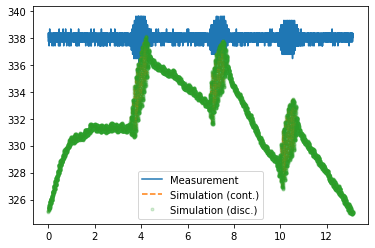

In [9]:
plt.plot(time_steps, angular_speeds[0,:], label='Measurement')
plt.plot(tout_mat, yout_mat[:,0], '--', label='Simulation (cont.)')
plt.plot(dtout_mat, dyout_mat[:,0], '.', label='Simulation (disc.)', alpha=0.2)
plt.legend()
plt.show()

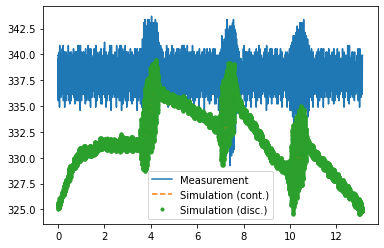

In [10]:
plt.plot(time_steps, angular_speeds[1,:], label='Measurement')
plt.plot(tout_mat, yout_mat[:,1], '--', label='Simulation (cont.)')
plt.plot(dtout_mat, dyout_mat[:,1], '.', label='Simulation (disc.)')
plt.legend()
#plt.xlim(6,12)
#plt.ylim(325,345)
plt.show()

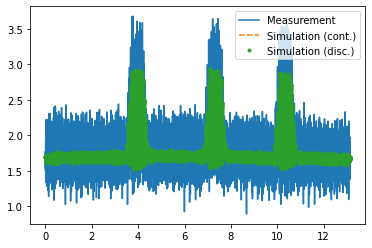

In [11]:
plt.plot(time_steps, shaft_torque, label='Measurement')
plt.plot(tout_mat, yout_mat[:,2], '--', label='Simulation (cont.)')
plt.plot(dtout_mat, dyout_mat[:,2], '.', label='Simulation (disc.)')
plt.legend()
plt.show()

# Input and state estimation functions

In [12]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))
    
    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O

In [13]:
def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)
    
    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B, 
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z
        
        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))
        
        # then add the impulse responses
        A_power2 = np.copy(A)
        
        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))
            
        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))
        
        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1
    
    return gamma

In [14]:
def Gamma(A,B,C,N):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    mat_list = []
    n = (C@B).shape[0]
    m = (C@B).shape[1]
    for i in range(N): # generate row
        tmp = []
        for j in range(N): # loop through A^j*B
            if j <= i:
                tmp.append(C@np.linalg.matrix_power(A,i-j)@B)
        if i < N-1:
            tmp.append(np.zeros((n, m*(N-1-i))))
        mat_list.append(tmp)
        G = np.block(mat_list)
        #add zero row and column
        n,m = (C@B).shape
        ng,mg = G.shape
        G = np.append(np.zeros((n,mg)),G,axis=0)
        G = np.append(G,np.zeros((n+ng,m)),axis=1)
    return G

In [15]:
def L(input_shape):
    '''
    The regularization matrix L.

    Parameters:

    input_shape : float
        Input vector shape used to determine L matrix shape.

    Returns:

    L : ndarray
        The regularization matrix
    '''
    I = np.eye(input_shape)
    L = -I + np.diag(np.ones(input_shape-1), 1)

    return I

In [16]:
def convex_optimization_problem(meas, obsrv, gamm, regu, lam=1):
    '''
    Convex optimization methods using the cvxpy library.
    '''
    d = cp.Variable((gamm.shape[1], 1))
    x = cp.Variable((obsrv.shape[1], 1))
    #x = np.zeros((obsrv.shape[1], 1))
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    # Tikhonov:
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.sum_squares(regu @ d))
    
    # LASSO:
    # objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.pnorm(regu @ d, 1))
    
    prob = cp.Problem(objective)
    prob.solve()

    return d.value, x.value

# Impulse test

In [22]:
def sim(A,B,C,u,x0):
    n = A.shape[0]
    r = C.shape[0]
    x = np.concatenate([x0,np.zeros((n,N-1))],axis=1)
    #x = np.zeros((n,N))
    y = np.zeros((r,N))
    for k in range(N):
        if k==0:
            y[:,k] = C@x[:,k]
        else:
            x[:,k] = A@x[:,k-1] + B@u[:,k-1]
            y[:,k] = C@x[:,k]
    return x, y

In [25]:
t = np.arange(0, 1.200, 0.002)
d_t = np.mean(np.diff(t))
N = len(t)

# Impulse load applied at node 0.
impulse_ex = np.zeros((len(t), 2))
impulse_ex[:,0] = 1

dxout_imp, dyout_imp = sim(A_mat_d, B_mat_d, C_mat, impulse_ex.T, np.zeros((A_mat_d.shape[0], 1)))
#dtout_imp, dyout_imp, dxout_imp = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, d_t), impulse_ex, t=t)
#O_test = O(A_mat_d, C_mat, n)
G_test = gamma(A_mat_d, B_mat_d, C_mat, N)

impulse_ex_reshaped = np.reshape(impulse_ex.T, (-1, 1))
y_hat = G_test @ impulse_ex_reshaped

meases = np.hstack(np.vsplit(y_hat, N))

(3, 600)


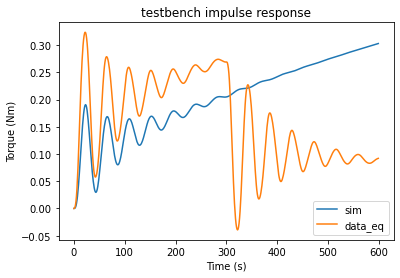

In [31]:
print(meases.shape)

plt.plot(dyout_imp[-1,:], label='sim')
plt.plot(meases[-1,:], label='data_eq')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('testbench impulse response')
plt.show()

# Load and preprocess data
* motor sampling rate ~1kHz
* sensor sampling rate ~3kHz

In [ ]:
# time | MotoVelocitySet | MotorVelocity | MotorTorqueSet | MotorTorque | PropellerVelocitySet | PropellerVelocity | PropellerTorqueSet | PropellerTorque
m_data = np.genfromtxt('../data/testbench_data/motor/baseline_500rpm_Constant_Torque_1%_motor_GP1.csv', delimiter=',')
motor_data = np.delete(m_data, 0, 0) # delete header row

# time | enc1_ang | enc1_time | enc2_ang | enc2_time | enc3_ang | enc3_time | enc4_ang | enc4_time | enc5_ang | enc5_time | acc1 | acc2 | acc3 | acc4 | Torq1 | Torq2
s_data = np.genfromtxt('../data/testbench_data/sensor/baseline_500rpm_Constant_Torque_1%_GP1.csv', delimiter=',')
sensor_data = np.delete(s_data, 0, 0) # delete header row

In [ ]:
t_motor = motor_data[:,0]
tau_motor = motor_data[:,4]
tau_propeller = motor_data[:,8]

In [ ]:
plt.plot(t_motor, tau_motor, label='motor')
plt.plot(t_motor, tau_propeller, label='propeller')
plt.legend()
plt.show()

In [ ]:
# motor sampling rate is ~1/3 of sensor sampling rate so every third sensor sample is used
t_sensor = sensor_data[:,0]
i_max = len(t_sensor) - (len(t_sensor) % len(t_motor))
sensor_tmp = sensor_data[:i_max,:] # len(sensor_data) == 3*len(motor_data)
sensor_data_third = sensor_tmp[::3,:] # len(sensor_data) == len(motor_data)

In [ ]:
t_sensor_third = sensor_data_third[:,0]
torq_sensor1 = sensor_data_third[:,-2]
torq_sensor2 = sensor_data_third[:,-1]

In [ ]:
omega1 = np.gradient(sensor_data_third[:,1]*(np.pi/180), sensor_data_third[:,2])
omega2 = np.gradient(sensor_data_third[:,3]*(np.pi/180), sensor_data_third[:,4])
omega3 = np.gradient(sensor_data_third[:,5]*(np.pi/180), sensor_data_third[:,6])
omega4 = -np.gradient(sensor_data_third[:,7]*(np.pi/180), sensor_data_third[:,8])
omega5 = np.gradient(sensor_data_third[:,9]*(np.pi/180), sensor_data_third[:,10])
omega1[np.isnan(omega1)] = 0
omega2[np.isnan(omega2)] = 0
omega3[np.isnan(omega3)] = 0
omega4[np.isnan(omega4)] = 0
omega5[np.isnan(omega5)] = 0
plt.plot(t_sensor_third, omega1, label='enc_1')
plt.plot(t_sensor_third, omega2, label='enc_2')
plt.plot(t_sensor_third, omega3, label='enc_3')
plt.plot(t_sensor_third, omega4, label='enc_4')
plt.plot(t_sensor_third, omega5, label='enc_5')
plt.legend()
plt.show()

In [ ]:
# torque sensor data is mixed up: V -> Nm conversion is redone
torq1 = (torq_sensor1/10)*4
torq2 = (torq_sensor2/4)*10

plt.plot(t_sensor_third, torq1, label='Torque sensor 1')
plt.plot(t_sensor_third, torq2, label='Torque sensor 2', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
n = 1000 # number of measurements in the batch
k = 10000

y = np.vstack((omega1[k:k+n], omega2[k:k+n], omega4[k:k+n], omega5[k:k+n], torq1[k:k+n], torq2[k:k+n]))
Y = np.reshape(y.T,(-1,1))

C_mat_d = np.zeros((6, B_mat_d.shape[0]))
C_mat_d[0,6] += 1 # enc 1
C_mat_d[1,7] += 1 # enc 2
C_mat_d[2,13] += 1 # enc 4
C_mat_d[3,14] += 1 # enc 5
C_mat_d[4,30] += 1 # torque 1
C_mat_d[5,40] += 1 # torque 2

reg = L(B_mat_d.shape[1]*n)

In [ ]:
observer = O(A_mat_d, C_mat_d, n)
gam = gamma(A_mat_d, B_mat_d, C_mat_d, n)

In [ ]:
u_hat, x_hat = convex_optimization_problem(Y, observer, gam, reg, lam=0.02)

In [ ]:
print(u_hat)
print(x_hat)

# TODO
* impulse response looks strange
* problem with gears?